# D212 PA 3 code - Doug Haunsperger

## Data Preparation

### Do initial package import and data read

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv('medical_time_series.csv')
#view first 5 rows
df.head(5)

,Day,Revenue
0,1,0.000000
1,2,-0.292356
2,3,-0.327772
3,4,-0.339987
4,5,-0.124888


Set `Day` column to index

In [2]:
df.set_index('Day')

,Revenue
Day,
1,0.000000
2,-0.292356
3,-0.327772
4,-0.339987
5,-0.124888
...,...
727,15.722056
728,15.865822
729,15.708988


### C1. Line Graph

Here is a line graph of the realization of the input data set.

<Axes: >

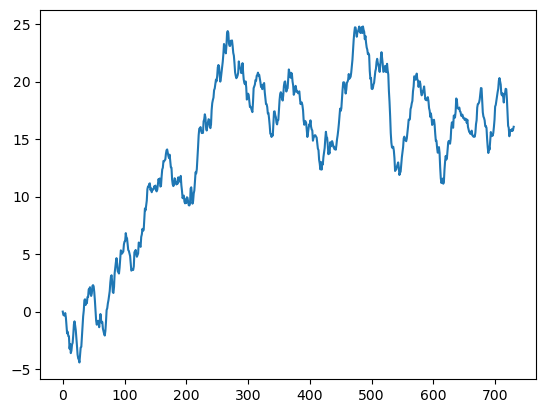

In [3]:
df.Revenue.plot()

### C2. Time Step Formatting

In [4]:
print(df.describe())
print(df.info())

              Day     Revenue
count  731.000000  731.000000
mean   366.000000   14.179608
std    211.165812    6.959905
min      1.000000   -4.423299
25%    183.500000   11.121742
50%    366.000000   15.951830
75%    548.500000   19.293506
max    731.000000   24.792249
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.6 KB
None


This time series is formatted as a daily chart, with 731 records and no gaps present in the data.

### C3. Evaluate Stationarity

Stationarity - or lack of an overall trend in the data - is evaluated through the Augmented Dickey-Fuller test. The `adfuller()` function from the `statsmodels` package will accomplish this.

In [5]:
# Code ref: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/ (Prabhakaran, n.d.) 
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Revenue)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.218319
p-value: 0.199664


P-value of 0.2 indicates that one cannot reject the null hypothesis that the series is non-stationary. Try a diff on the series and retest:

In [6]:
result = adfuller(df.Revenue.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %e' % result[1])

ADF Statistic: -17.374772
p-value: 5.113207e-30


Now there is a very significant result with a 1st order difference. Plot the resulting series:

<Axes: >

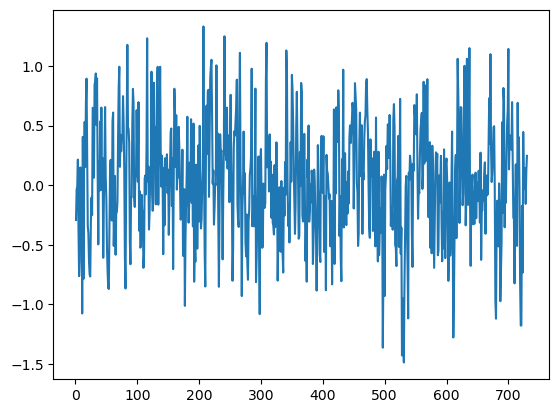

In [7]:
df.Revenue.diff().dropna().plot()

Create train-test split for out-of-time cross-validation and output train/test files. 

Note - train/test is not randomized because "the order sequence of the time series should be intact in order to use it for forecasting." (Prabhakaran, n.d.)

Note also that the output files are based on the non-differenced data since the ARIMA model will handle the differencing using a `d` parameter of d=1.

In [8]:
# Approx 2 years of data. Split into first 18 months (~ 547 days), last 6 months
train = df.Revenue[:547]
test = df.Revenue[547:]

# Also output differenced data
df_d = df.Revenue.diff().dropna().copy(deep=True)

train.to_csv("train.csv", index=False)
test.to_csv("test.csv", index=False)
df_d.to_csv("difference_1.csv", index=False)

## Data Analysis & Model Identification

### D1. Findings & Visualizations

#### Check for Seasonality, Trend; Plot decomposition

7 0.03389461393396866
8 0.1026302002341985
14 0.25015445450146506
23 0.29420912411648636
25 0.3178594400012178
27 0.37732716662250726
28 0.37902884252646396
29 0.3843976535319445
30 0.45635891708796555
32 0.4777857659906336
37 0.5391212441615979
39 0.6245402903837007
43 0.6337591456761923
45 0.8205124164437018
49 0.9437095190724906
50 1.1159073435021423
53 1.278226410647288
78 1.3522448933152225
79 1.414494344519936
80 1.5120758610970633


<Axes: ylabel='Resid'>

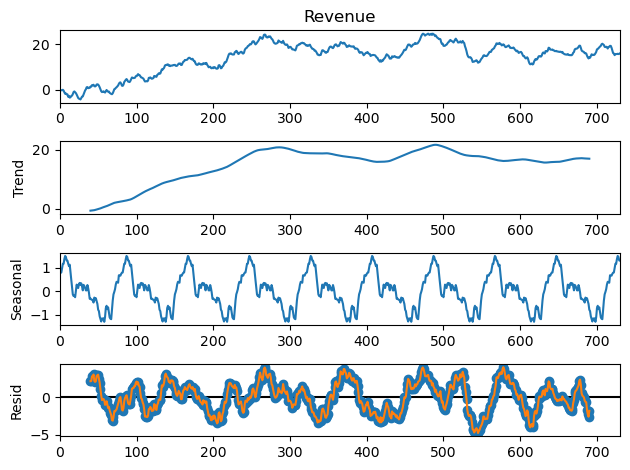

In [9]:
# Code ref: https://towardsdatascience.com/finding-seasonal-trends-in-time-series-data-with-python-ce10c37aa861 (Hayes, 2021). 
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime

# Since the index is not a datetime object, I need to specify the periodicity of the data for seasonal_decompose. Loop through all values from weekly (7) to quarterly (91):
max_seasonality_value = 0
max_seasonality_period = 0
for per in range (7,92,1):
    decomp_result = seasonal_decompose(df.Revenue, model="add", period=per)
    
    if np.max(decomp_result.seasonal) > max_seasonality_value:
        max_seasonality_value = np.max(decomp_result.seasonal)
        max_seasonality_period = per
        print(per, max_seasonality_value)
        

decomp_result_max = seasonal_decompose(df.Revenue, model="add", period=max_seasonality_period)
trend = decomp_result_max.trend
seas = decomp_result_max.seasonal
resids = decomp_result_max.resid

decomp_result_max.plot();

resids.plot()


The above analysis finds a slight "seasonal" signal at a period of 80 days, but the residuals (+/- 5) are much larger than the supposed seasonal adjustment of +/- 1.5.
There is an upward trend inthe revenue data for the first ~275 days, that then levels off for the remainder of the series.

By inspection, the residuals drift around the x-axis with no overall trend.

#### Autocorrelation Function

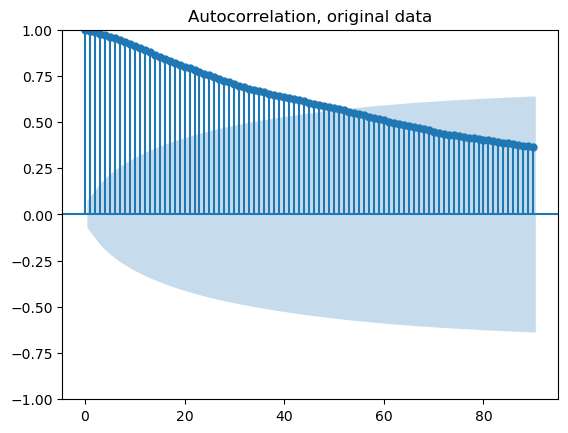

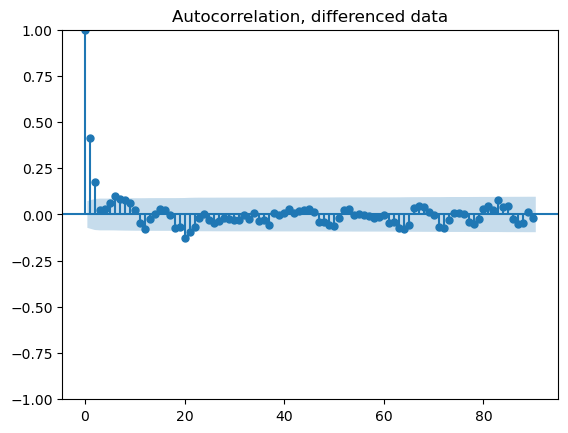

In [10]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df.Revenue, lags=90, title='Autocorrelation, original data')
plt.show()

plot_acf(df_d, lags=90, title='Autocorrelation, differenced data');

#### Spectral Analysis

C:\Users\dough\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


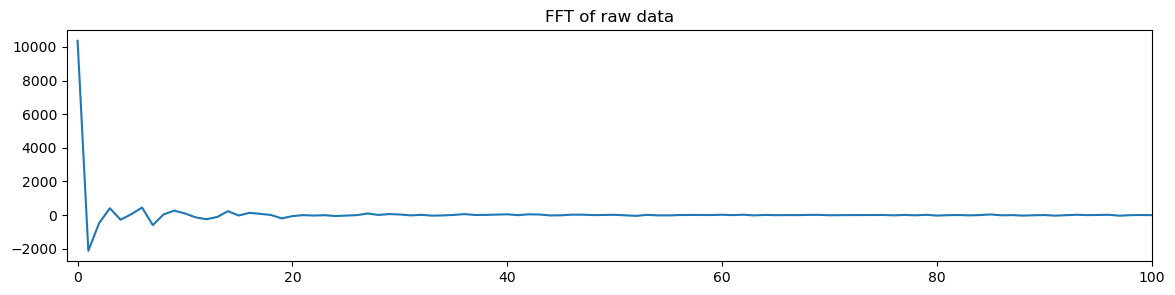

In [11]:
# Code ref: https://ataspinar.com/2020/12/22/time-series-forecasting-with-stochastic-signal-analysis-techniques/ (Taspinar, A., 2020)
y_vals = df.Revenue

fig, ax = plt.subplots(figsize=(14,3))
ax.plot(np.fft.rfft(y_vals))
ax.set_title('FFT of raw data')

plt.xlim(-1, 100)
plt.show()



There is a pronounced high value at low frequency; this is due to the overall trend in the raw data. I will now run the Fourier transform on the detrended data:

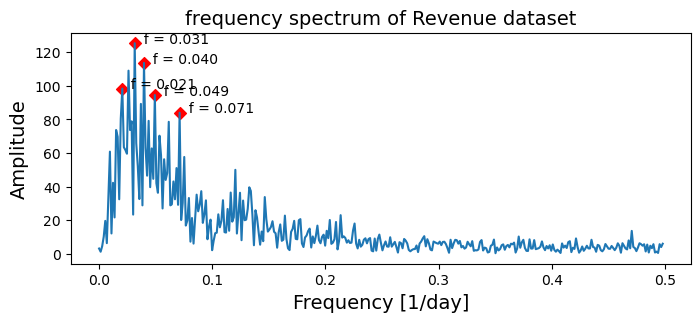

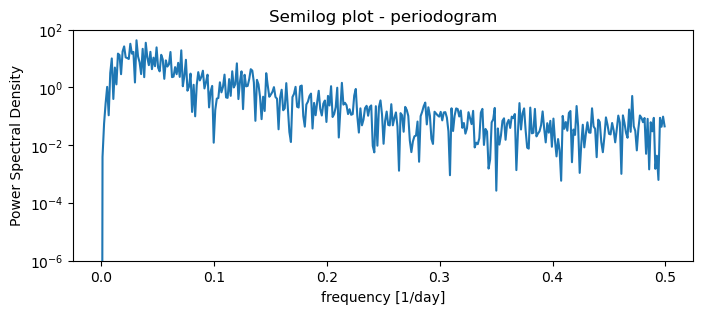

In [12]:
from scipy.signal import savgol_filter, find_peaks, periodogram

yvalues_trend = savgol_filter(y_vals,25,1)
yvalues_detrended = y_vals - yvalues_trend

fft_y_det  = np.fft.fft(yvalues_detrended)
fft_y = np.abs(fft_y_det[:len(fft_y_det)//2])
indices_peaks = find_peaks(fft_y, height=80, distance=6)
indices_peaks = indices_peaks[0]                             
fft_x_ = np.fft.fftfreq(len(yvalues_detrended))
fft_x = fft_x_[:len(fft_x_)//2]


x_peaks = fft_x[indices_peaks]
y_peaks = fft_y[indices_peaks]

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(fft_x, fft_y)
ax.scatter(x_peaks, y_peaks, color='red',marker='D')
ax.set_title('frequency spectrum of Revenue dataset', fontsize=14)
ax.set_ylabel('Amplitude', fontsize=14)
ax.set_xlabel('Frequency [1/day]', fontsize=14)
 
for idx in indices_peaks:
    x,y = fft_x[idx], fft_y[idx]
    text = "  f = {:.3f}".format(x,y)
    ax.annotate(text, (x,y))
    
plt.show()

# Code ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html#scipy.signal.periodogram (Scipy.org, 2024).
f, Pxx_den = periodogram(yvalues_detrended)
plt.figure(figsize=(8,3))
plt.semilogy(f, Pxx_den)
plt.ylim([1e-6,100])
plt.title('Semilog plot - periodogram')
plt.xlabel('frequency [1/day]')
plt.ylabel('Power Spectral Density');


I used the find_peaks function from scipy to look for peaks in the frequency spectrum of the de-trended revenue dataset shows a few small peaks, but when plotted on a semilog chart, these peaks disappear into the noise floor.

### D2. ARIMA Model Fit

In the differencing analysis above, I already showed that the `d` parameter of the model should be 1, so it only remains to find the order of the AR term `p` and the MA term `q`.

#### Find `p`
I use the Partial Autocorrelation plot:

C:\Users\dough\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


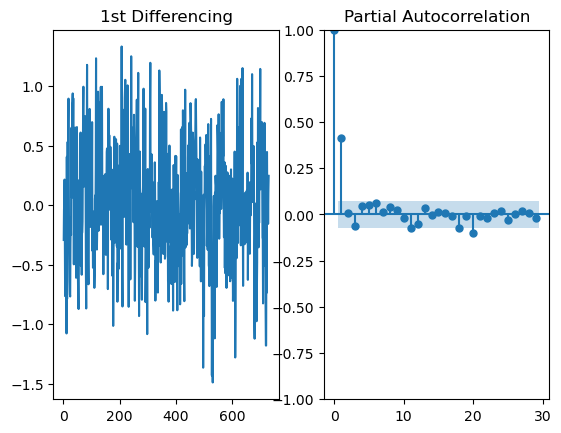

In [13]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(df_d); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df_d, ax=axes[1]);

Only the lag-1 partial autocorrelation is significantly different from 0, so that indicates the `p` AR order term should be 1.

#### Find `q`

Recall the ACF of the differenced data looked like this:

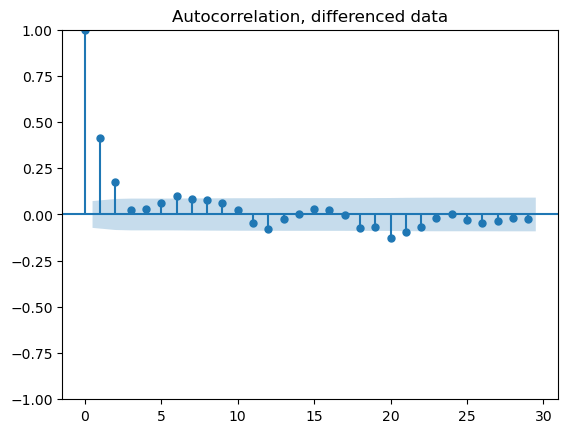

In [14]:
plot_acf(df_d, title='Autocorrelation, differenced data');

The first 2 lags have a significant autocorrelation, which indicates that 2 is likely a good choice for `q`. This gives the `(p,d,q)` of the ARIMA model as (1,1,2).

#### Fit an ARIMA model to the train data

In [15]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

arima = ARIMA(train, trend='t',order=(1,1,2))
result = arima.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  547
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -329.625
Date:                Mon, 22 Apr 2024   AIC                            669.249
Time:                        13:25:27   BIC                            690.762
Sample:                             0   HQIC                           677.659
                                - 547                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0220      0.032      0.690      0.490      -0.041       0.085
ar.L1          0.1200      0.191      0.627      0.531      -0.255       0.495
ma.L1          0.2771      0.189      1.464      0.143      -0.094       0.648
ma.L2          0.1839      0.073      2.506      0.012       0.040       0.328
sigma2         0.1958      0.013     15.147      0.000       0.170       0.221
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.93
Prob(Q):                              0.98   Prob(JB):                         0.38
Heteroskedasticity (H):               1.08   Skew:                            -0.03
Prob(H) (two-sided):                  0.59   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

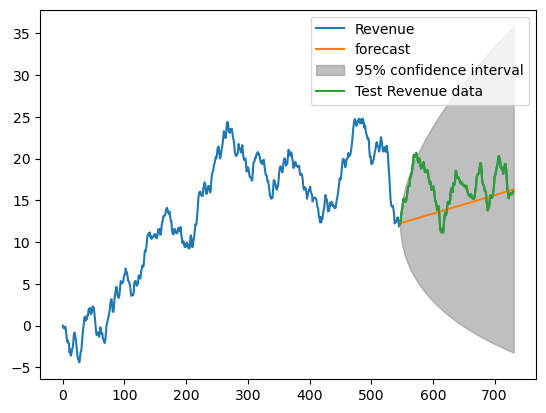

In [16]:
fig, ax = plt.subplots()
df.Revenue.plot(ax=ax)
plot_predict(result, start=547, end=731, ax=ax)
test.plot(ax=ax,label='Test Revenue data')
plt.legend()
plt.show()

All the above is the procedure to find an ARIMA model manually. There exists an automated way using the pmdarima package. Let's check to see if it finds the same model or not.

In [17]:
#import sys
#!{sys.executable} -m pip install pmdarima
import pmdarima as pm
automod = pm.auto_arima(train,start_p=0,start_q=0,test='adf', \
                        # Search for p & q between 0 and 4; use adfuller for d determination
                        max_p=4,max_q=4, \
                        # No seasonality
                        seasonal=False, \
                        stepwise=False, trend=None,
                        trace=True, with_intercept=True)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=767.498, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=691.444, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=667.740, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=669.145, Time=0.07 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=670.996, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=670.883, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=672.559, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=669.249, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=670.767, Time=0.34 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=672.676, Time=0.51 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=672.407, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=671.328, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=670.349, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=672.708, Time=0.51 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=669.366, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] i

ARIMA(0,1,2) performs slightly better based on the AIC estimator value. I will rerun the model fit and prediction with no autoregressive component.

In [18]:
revised_arima = ARIMA(train, trend='t', order=(0,1,2))
revised_result = revised_arima.fit()

revised_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  547
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -329.870
Date:                Mon, 22 Apr 2024   AIC                            667.740
Time:                        13:25:31   BIC                            684.951
Sample:                             0   HQIC                           674.468
                                - 547                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0221      0.031      0.718      0.473      -0.038       0.082
ma.L1          0.3901      0.042      9.324      0.000       0.308       0.472
ma.L2          0.2173      0.042      5.189      0.000       0.135       0.299
sigma2         0.1959      0.013     15.296      0.000       0.171       0.221
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.80
Prob(Q):                              0.86   Prob(JB):                         0.41
Heteroskedasticity (H):               1.09   Skew:                            -0.04
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

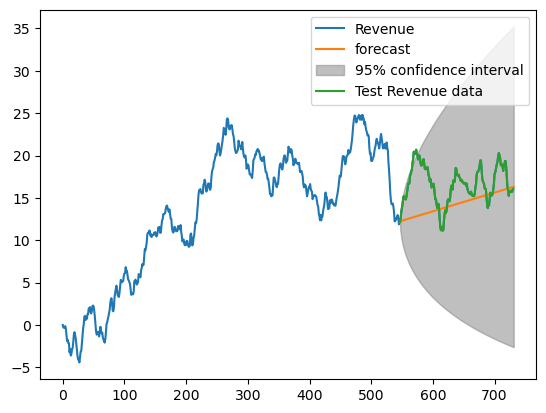

0.15358598466166667


In [19]:
fig, ax = plt.subplots()
df.Revenue.plot(ax=ax)
plot_predict(revised_result, start=547, end=731, ax=ax)
test.plot(ax=ax,label='Test Revenue data')
plt.legend()
plt.show()

forecast = revised_result.forecast(184)

mape = np.mean(np.abs(forecast - test)/np.abs(test))
print(mape)


I get a mean absolute percentage error of 15.4% on the model prediction vs. the test data.
Nearly all the test data is within the 95% confidence bounds.

### D3. Forecast

Now I will refit the model on the full 731-record data set and forecast into the future.

14


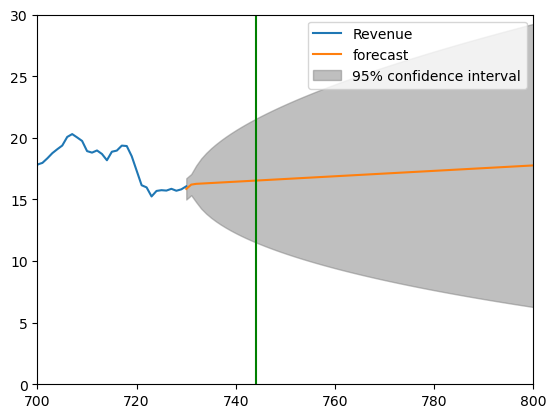

In [20]:
forecast_mod = ARIMA(df.Revenue, trend='t', order=(0,1,2))
fc = forecast_mod.fit()

fig, ax = plt.subplots()
df.Revenue.plot(ax=ax)
plot_predict(fc, start=730, end=800, ax=ax)
plt.xlim(700,800)
plt.ylim(0,30)

# Check for first prediction where CI is greater than $10M 
big_ci = 10
ci=np.asarray(fc.get_prediction(start=730, end=790).conf_int(0.05))
index_first=None
for index, check in enumerate((ci[:,1]-ci[:,0]) > big_ci):
    if check == True:
        index_first = index
        break
plt.axvline(x=730+index_first, color="g")
print (index_first)


plt.show()

After a forecast period of 14 days, the 95% confidence interval grows larger than $10M, indicating increasing uncertainty in the forecast at longer time scales.